In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import altair as alt 

In [2]:
train = pd.read_csv('data/sales_train.csv.gz')
items = pd.read_csv('data/items.csv')
categories = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')

test = pd.read_csv('data/test.csv.gz')
submission = pd.read_csv('data/sample_submission.csv.gz')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
train.shape

(2935849, 6)

In [5]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
test.shape

(214200, 3)

In [7]:
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


As we can see, the test set is different in size and structure when compared to the training set. We have the features 'shop_id' and 'item_id' in the test set, which are present in the trianing set as well. Each observation in the test set has an ID associated with it. If we look at our submission file, we need to submit the monthly count (item_cnt_month) for that particular ID. This means we need to predict a number for the monthly sale quantity of a particular item at a particular shop.

Let's look at the distribution of the training and test set to understand our dataset better and check for overlap, or lack thereof.

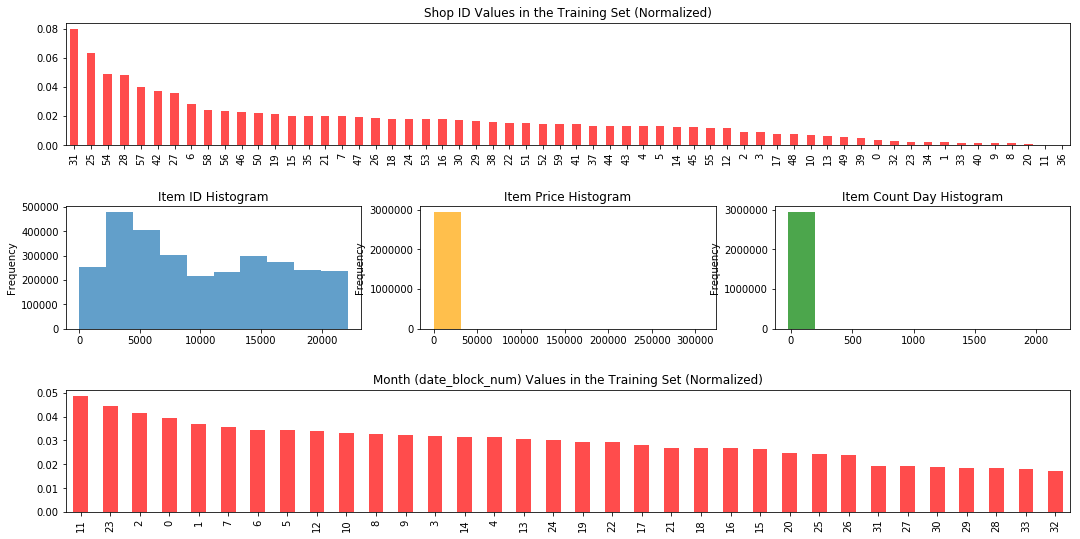

In [8]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train['shop_id'].value_counts(normalize=True).plot(kind='bar', color = 'red', alpha=0.7)
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
train['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram')

plt.subplot2grid((3,3), (1,1))
train['item_price'].plot(kind='hist', alpha=0.7, color='orange')
plt.title('Item Price Histogram')

plt.subplot2grid((3,3), (1,2))
train['item_cnt_day'].plot(kind='hist', alpha=0.7, color='green')
plt.title('Item Count Day Histogram')

plt.subplot2grid((3,3), (2,0), colspan = 3)
train['date_block_num'].value_counts(normalize=True).plot(kind='bar', color = 'red', alpha=0.7)
plt.title('Month (date_block_num) Values in the Training Set (Normalized)')
plt.show()

The above graphs are a nice way to look at the raw distribtion of the test dataset. Here are some observations:

1. We have 60 'shop_id's but there is an uneven distribtution of these in the dataset. Four (<7%) of these shops make up ~25 percent of this dataset. These are shops (31, 25, 54, 28).


2. The Item IDs seem to have variations in frequency. We can't attribute a reason to this yet but we can inspect this further. Certain cateogeries are bound to sell better and maybe items under the same category are closer to each other as far as their ID distributions are concerned


3. From the vast empty spaces in the histograms of 'item_price' and 'item_cnt_day', we can infer that there are outliers in their distribution. **Let's write some simple code below to put a value to these outliers.**


4. Plotting the individual months from January 2013 to October 2015, it is interesting to see that the block month 12, corresponding to December 2013, had the highest number of sales. Month 23, which corresponds to December 2014, had the second highest number of sales. Shortly, we will use some better graphs to observe the monthly sale trends.

In [9]:
train['item_id'].value_counts(ascending=False)[:5]

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
Name: item_id, dtype: int64

In [10]:
train['item_cnt_day'].sort_values(ascending=False)[:5]

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
Name: item_cnt_day, dtype: float64

In [11]:
train['item_price'].sort_values(ascending=False)[:5]

1163158    307980.0
885138      59200.0
1488135     50999.0
2327159     49782.0
2910156     42990.0
Name: item_price, dtype: float64

Having a look at the item id 20949 that has been sold the most number of times, it is a plastic bag!

In [12]:
items.loc[items['item_id']==20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


In [13]:
categories.loc[categories['item_category_id']==71]

,item_category_name,item_category_id
71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71


And just to satisfy my curiosity bowels, there is only one item under item category 71

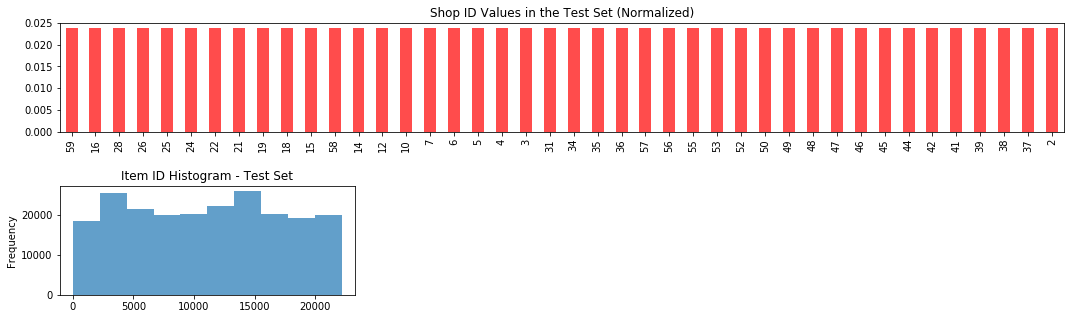

In [14]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
test['shop_id'].value_counts(normalize=True).plot(kind='bar', color = 'red', alpha=0.7)
plt.title('Shop ID Values in the Test Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
test['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram - Test Set')
plt.show()

1. The Shop Id's are evenly spread out, unlike the training set. The font size of labels quickly tells me that there are certain Shop Id's missing in the test set as the bars in the training set 'shop_id' plot were more tightly packed.


2. While item id's in the histogram are binned, the spikes are less in the test set. The test set is much smaller in shape than the training set, and naturally, the frequency values are significantly lower. It is tough to be draw more insights from this histogram.

It seems there might be some values of shop_id and item_id completely missing in the test set. Let's have a closer look and put some numbers or percentages to these missing values.

In [15]:
shops_train = train['shop_id'].nunique()
shops_test = test['shop_id'].nunique()
print('Shops in Training Set: ', shops_train)
print('Shops in Test Set: ', shops_test)

Shops in Training Set:  60
Shops in Test Set:  42


However, this doesn't mean that the training set contains all of the shops present in the test set. For that, we need to see if every element of the test set is present in the training set. Let's write some simple code to see if the test set list is a subset of the training set list.

In [16]:
shops_train_list = list(train['shop_id'].unique())
shops_test_list = list(test['shop_id'].unique())

flag = 0
if(set(shops_test_list).issubset(set(shops_train_list))): 
    flag = 1
      
if (flag) : 
    print ("Yes, list is subset of other.") 
else : 
    print ("No, list is not subset of other.") 

Yes, list is subset of other.


Great, so all shops id's in the test set are also present in the training set. Let's see if this is true for the item_ids

In [17]:
items_train = train['item_id'].nunique()
items_test = test['item_id'].nunique()
print('Items in Training Set: ', items_train)
print('Items in Test Set: ', items_test)

Items in Training Set:  21807
Items in Test Set:  5100


There are a lot many more items in the training set than there are in the test set. However, this doesn't mean that the training set contains all of the items in the test set. For that, we need to see if every element of the test set is present in the training set. Let's write some simple code to achieve this.

In [18]:
items_train_list = list(train['item_id'].unique())
items_test_list = list(test['item_id'].unique())

flag = 0
if(set(items_test_list).issubset(set(items_train_list))): 
    flag = 1
      
if (flag) : 
    print ("Yes, list is subset of other.") 
else : 
    print ("No, list is not subset of other.") 

No, list is not subset of other.


Well then, this means there are certain items that are present in the test set but completely absent in the training set! Can we put a number to this to get an intuition?

In [19]:
len(set(items_test_list).difference(items_train_list))

363

There are 363 items that are present in the test set but completely absent in the training set. This doesn't mean that the sales prediction against those items must be zero as new items can be added to the market or we simply didn't possess the data for those items before. The fascinating questions pops though, how do you go about predicting them?

Before we do that, let's find out more about the 5100 items in the test set. What categories to they belong to? What categories do we not have to make predictions in the test set for

In [20]:
categories_in_test = items.loc[items['item_id'].isin(sorted(test['item_id'].unique()))].item_category_id.unique()

In [21]:
categories.loc[categories['item_category_id'].isin(categories_in_test)]
categories.loc[~categories['item_category_id'].isin(categories_in_test)]

,item_category_name,item_category_id
1,Аксессуары - PS2,1
4,Аксессуары - PSP,4
8,Билеты (Цифра),8
10,Игровые консоли - PS2,10
13,Игровые консоли - PSP,13
14,Игровые консоли - PSVita,14
17,Игровые консоли - Прочие,17
18,Игры - PS2,18
32,"Карты оплаты (Кино, Музыка, Игры)",32
39,Кино - Blu-Ray 4K,39


Now, let's generate sales data for each shop and item present in the training set. We should do this for each month, as the final prediction is for the monthly count of sales for a particular shop and item

In [22]:
train['date'] =  pd.to_datetime(train['date'], format='%d.%m.%Y')

In [23]:
from itertools import product

In [24]:
# Testing generation of cartesian product for the month of January in 2013

shops_in_jan = train.loc[train['date_block_num']==0, 'shop_id'].unique()
items_in_jan = train.loc[train['date_block_num']==0, 'item_id'].unique()
jan = list(product(*[shops_in_jan, items_in_jan, [0]]))

In [25]:
print(len(jan))

365175


As we can see, January 2013 contains 365,175 intersections of shops and items. Most of these will have no sales and we can verify this once we check our training set, which has been grouped by month, to see which 'items' x 'shops' combinations have a sale count associated with them.

But before that, we need to generate this cartesian product for all 33 months in the training set. But wait, before generating it for all months, I will generate it for February 2013, concatenate it with January 2013 and produce a dataframe.

In [26]:
# Testing generation of cartesian product for the month of February in 2013

shops_in_feb = train.loc[train['date_block_num']==1, 'shop_id'].unique()
items_in_feb = train.loc[train['date_block_num']==1, 'item_id'].unique()
feb = list(product(*[shops_in_feb, items_in_feb, [1]]))

In [27]:
print(len(feb))

375728


In [28]:
cartesian_test = []
cartesian_test.append(np.array(jan))
cartesian_test.append(np.array(feb))

In [29]:
cartesian_test

[array([[   59, 22154,     0],
        [   59,  2552,     0],
        [   59,  2554,     0],
        ...,
        [   45,   628,     0],
        [   45,   631,     0],
        [   45,   621,     0]]), array([[   50,  3880,     1],
        [   50,  4128,     1],
        [   50,  4124,     1],
        ...,
        [   28, 12885,     1],
        [   28, 12791,     1],
        [   28, 13433,     1]])]

Ran out of memory when trying to create a dataframe from january and february lists. The trick was to convert the lists to a numpy array. The handy numpy method 'vstack' will shape the cartesian_test object in the right manner, so we can convert it into a long form dataframe.

In [30]:
cartesian_test = np.vstack(cartesian_test)

In [31]:
cartesian_test_df = pd.DataFrame(cartesian_test, columns = ['shop_id', 'item_id', 'date_block_num'])

In [32]:
cartesian_test_df.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [33]:
cartesian_test_df.shape

(740903, 3)

Viola! That worked. Time to extend this to all months using some neat code

In [34]:
months = train['date_block_num'].unique()

In [35]:
cartesian = []
for month in months:
    shops_in_month = train.loc[train['date_block_num']==month, 'shop_id'].unique()
    items_in_month = train.loc[train['date_block_num']==month, 'item_id'].unique()
    cartesian.append(np.array(list(product(*[shops_in_month, items_in_month, [month]]))))

In [36]:
cartesian_df = pd.DataFrame(np.vstack(cartesian), columns = ['shop_id', 'item_id', 'date_block_num'])

In [37]:
cartesian_df.shape

(10913850, 3)

In [38]:
x = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
x.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0


In [39]:
x.shape

(1609124, 4)

Now we need to merge our two dataframes. For the intersecting, we will simply put the values that exist in the dataframe x. For the remaining rows, we will sub in zero. Remember, the columns you want to merge on are the intersection of shop_id, item_id, and date_block_num

In [40]:
new_train = pd.merge(cartesian_df, x, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)

By default, pandas fills the dataframes with NaN. That's why we use fillna to replace all NaN's with zero.

In [41]:
del x
del cartesian_df
del cartesian
del cartesian_test
del cartesian_test_df
del feb
del jan

In [42]:
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [51]:
new_train['item_cnt_month'] = np.clip(new_train['item_cnt_month'], 0, 20)

In [64]:
new_train['shop_mean'] = new_train.groupby('shop_id')['item_cnt_month'].transform('mean')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,shop_mean
0,59,22154,0,1.0,0.197741
1,59,2552,0,0.0,0.197741
2,59,2554,0,0.0,0.197741
3,59,2555,0,0.0,0.197741
4,59,2564,0,0.0,0.197741


In [65]:
new_train['item_mean'] = new_train.groupby('item_id')['item_cnt_month'].transform('mean')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,shop_mean,item_mean
0,59,22154,0,1.0,0.197741,0.109870
1,59,2552,0,0.0,0.197741,0.021818
2,59,2554,0,0.0,0.197741,0.022222
3,59,2555,0,0.0,0.197741,0.066429
4,59,2564,0,0.0,0.197741,0.058524


Okay so what we need to do is fill the shop mean for all shops in the test set. To do this, we will get the unique shop ids present in the test set, iterate over them, locate all rows belonging to a shop, and fill them with a new column titled 'shop_mean' that contains the mean of the items sold in that shop

In [76]:
for i in test['shop_id'].unique():
    test.loc[test['shop_id'] == i, 'shop_mean'] = new_train.groupby('shop_id')['item_cnt_month'].mean()[i]
test.head()

,ID,shop_id,item_id,shop_mean
0,0,5,5037,0.180419
1,1,5,5320,0.180419
2,2,5,5233,0.180419
3,3,5,5232,0.180419
4,4,5,5268,0.180419


Now we need to do the same for item id means in the test set, but remember there are some items present in the test set that are not present in the training set. How do we deal with these values?

In [96]:
for i in test['item_id'].unique():
    try:
        test.loc[test['item_id'] == i, 'item_mean'] = new_train.groupby('item_id')['item_cnt_month'].mean()[i]
    except:
        test.loc[test['item_id'] == i, 'item_mean'] = new_train.groupby('item_id')['item_cnt_month'].mean().mean()
test.head()

,ID,shop_id,item_id,shop_mean,item_mean
0,0,5,5037,0.180419,1.949309
1,1,5,5320,0.180419,0.227724
2,2,5,5233,0.180419,1.656863
3,3,5,5232,0.180419,1.093023
4,4,5,5268,0.180419,0.227724


In [99]:
from xgboost import XGBClassifier
from matplotlib import pyplot

In [104]:
def xgtrain():
    classifier = XGBClassifier(n_estimators = 50, max_depth = 7, n_jobs = -1)
    classifier_ = classifier.fit(new_train.drop(['date_block_num', 'item_cnt_month'], axis=1), new_train['item_cnt_month'])
    classifier_.score(new_train.drop(['date_block_num', 'item_cnt_month'], axis = 1), new_train['item_cnt_month'])
    return classifier_

In [ ]:
classifier_ = xgtrain()

In [ ]:
predictions = classifier_.predict(test)
pyplot.bar(range(len(classifier_.feature_importances_)), classifier_.feature_importances_)
pyplot.show()